In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:
num_epochs = 50
batch_size = 100
learning_rate = 0.001
patience = 5  # for early stopping

In [ ]:

# Fashion MNIST dataset with data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [ ]:
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)


100%|██████████| 26421880/26421880 [00:01<00:00, 21038580.68it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 350721.54it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6384211.16it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 9379790.18it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [ ]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.01),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Linear(64*7*7, 1000)
        self.leaky_relu = nn.LeakyReLU(0.01)
        self.fc2 = nn.Linear(1000, 10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.leaky_relu(self.fc1(out))
        out = self.fc2(out)
        return out


In [ ]:
model = ConvNet().to(device)

In [ ]:
print(model)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=3136, out_features=1000, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=1000, out_features=10, bias=True)
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
best_loss = np.inf
epochs_without_improvement = 0
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [ ]:
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    avg_train_loss = running_loss / len(train_loader)
    avg_train_accuracy = 100 * correct_train / total_train
    train_losses.append(avg_train_loss)
    train_accuracies.append(avg_train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate validation accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    avg_val_loss = val_loss / len(test_loader)
    avg_val_accuracy = 100 * correct_val / total_val
    val_losses.append(avg_val_loss)
    val_accuracies.append(avg_val_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Accuracy: {avg_train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {avg_val_accuracy:.2f}%')

    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(), 'best_model.pth')  # Save best model
    else:
        epochs_without_improvement += 1
        if epochs_without_improvement >= patience:
            print("Early stopping triggered. Stopping training.")
            break
model.load_state_dict(torch.load('best_model.pth'))


Epoch [1/50], Train Loss: 0.2736, Train Accuracy: 89.78%, Val Loss: 0.2919, Val Accuracy: 89.03%
Epoch [2/50], Train Loss: 0.2457, Train Accuracy: 91.04%, Val Loss: 0.3028, Val Accuracy: 88.95%
Epoch [3/50], Train Loss: 0.2256, Train Accuracy: 91.56%, Val Loss: 0.2724, Val Accuracy: 90.11%
Epoch [4/50], Train Loss: 0.2106, Train Accuracy: 92.07%, Val Loss: 0.2509, Val Accuracy: 90.87%
Epoch [5/50], Train Loss: 0.1965, Train Accuracy: 92.51%, Val Loss: 0.2487, Val Accuracy: 90.80%
Epoch [6/50], Train Loss: 0.1832, Train Accuracy: 93.13%, Val Loss: 0.2583, Val Accuracy: 90.12%
Epoch [7/50], Train Loss: 0.1742, Train Accuracy: 93.45%, Val Loss: 0.2573, Val Accuracy: 91.10%
Epoch [8/50], Train Loss: 0.1655, Train Accuracy: 93.69%, Val Loss: 0.2543, Val Accuracy: 91.32%
Epoch [9/50], Train Loss: 0.1541, Train Accuracy: 94.14%, Val Loss: 0.2496, Val Accuracy: 91.19%
Epoch [10/50], Train Loss: 0.1440, Train Accuracy: 94.66%, Val Loss: 0.2570, Val Accuracy: 91.39%
Early stopping triggered. Sto

<ipython-input-15-b82dcec0ff3d>:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

In [ ]:
model.eval()
correct = 0
total = 0
all_labels = []
all_predictions = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

print(f'Test Accuracy: {100 * correct / total:.2f}%')


Test Accuracy: 90.90%


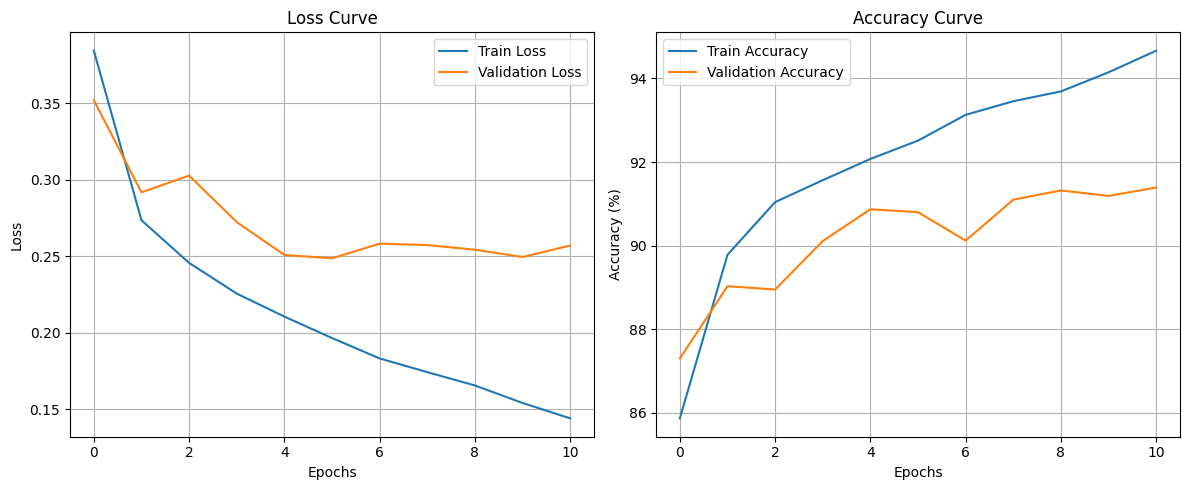

In [ ]:
# Plotting the loss curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


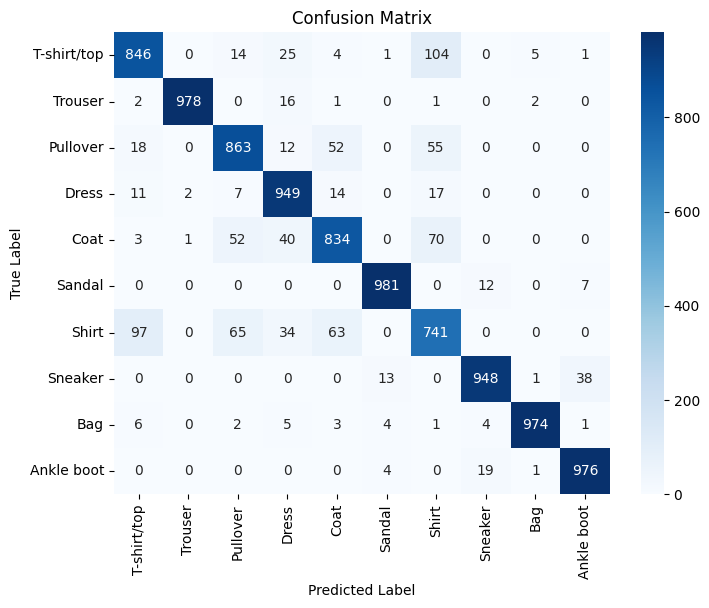

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Class names for Fashion MNIST
class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

Predicted class for /content/tshirt1.webp: T-shirt/top


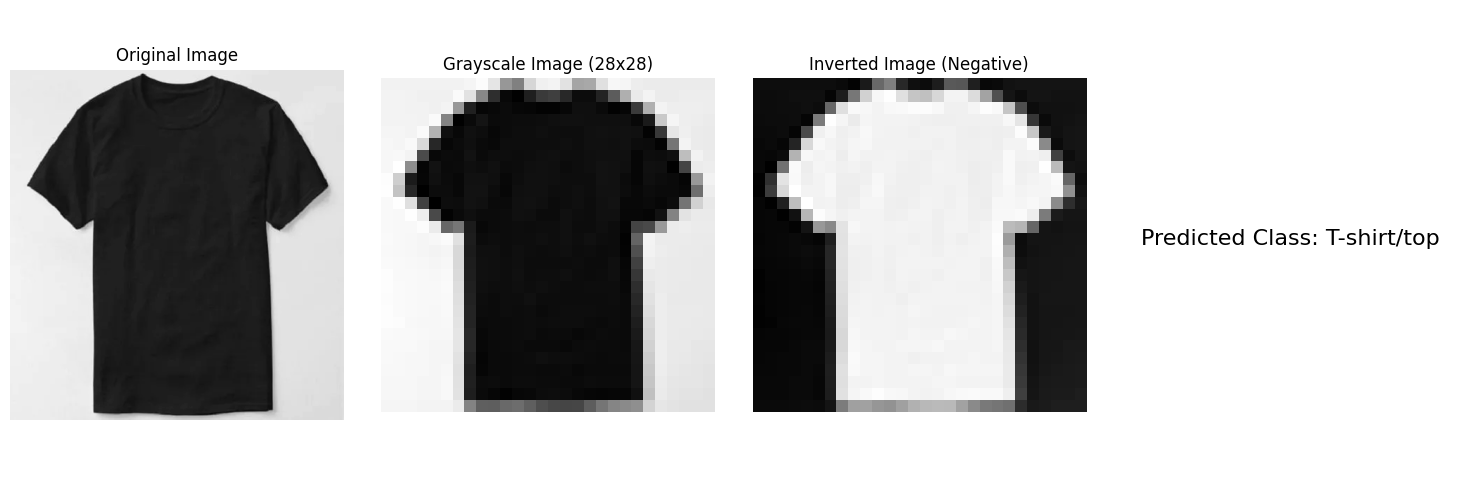

Predicted class for /content/pant.webp: Trouser


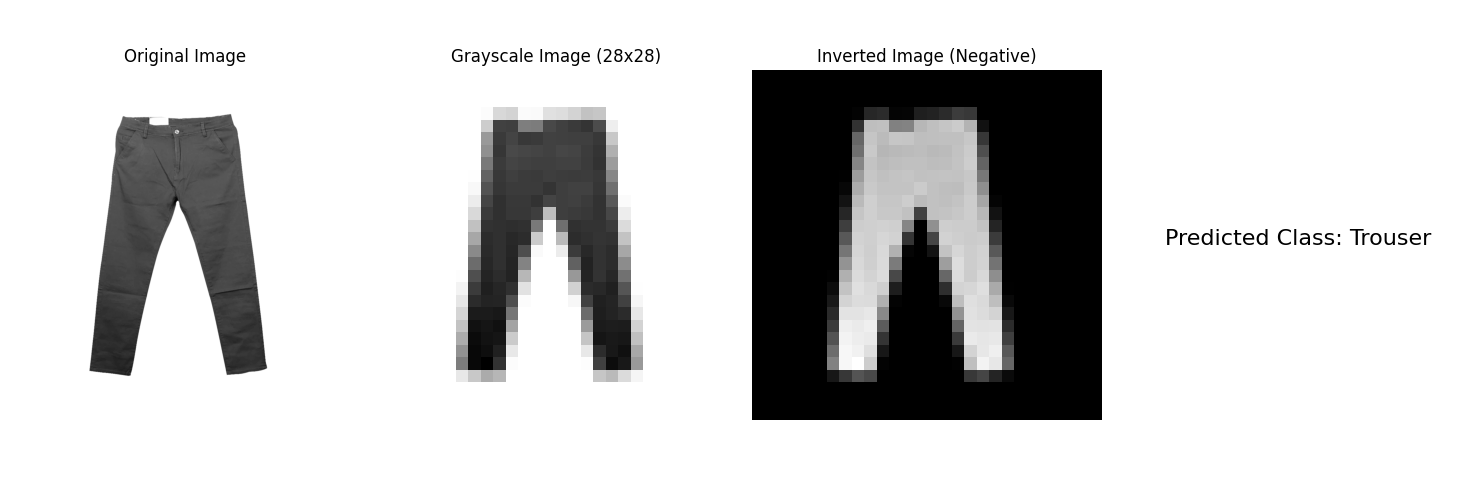

Predicted class for /content/aboot.webp: Ankle boot


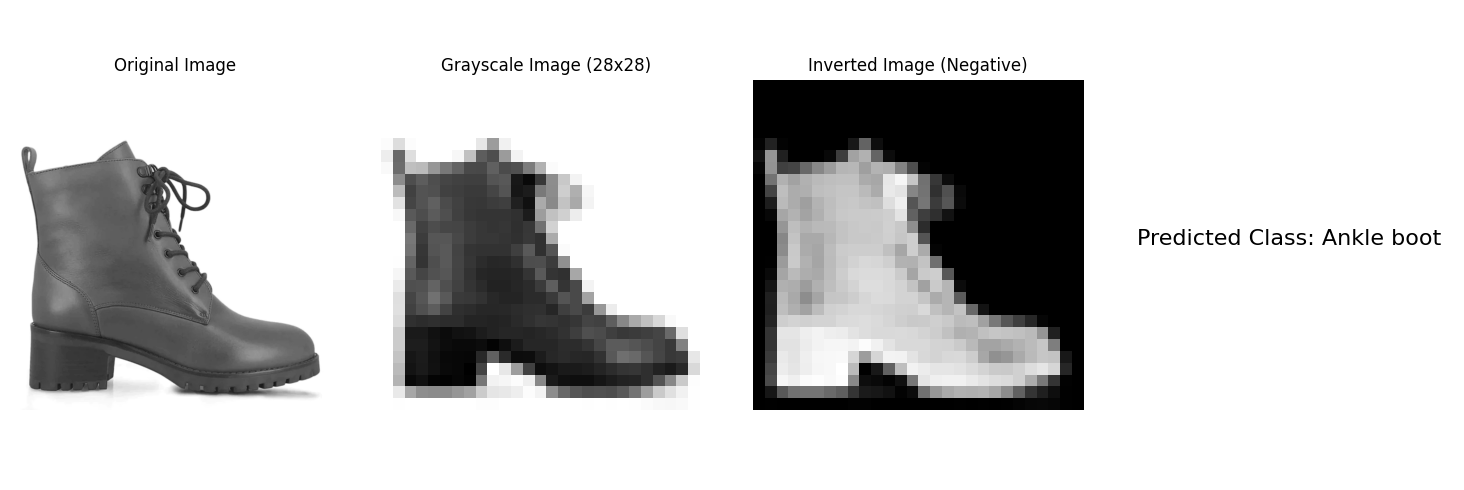

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import torch

# Define class names corresponding to Fashion MNIST labels
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

def predict_images(model, image_paths):
    for image_path in image_paths:
        # Load the original image
        original_image = Image.open(image_path).convert('L')  # Convert to grayscale
        original_image_resized = original_image.resize((28, 28))  # Resize to 28x28 pixels

        # Convert the image to a numpy array and invert it
        img_array = np.array(original_image_resized)
        img_array = 255 - img_array  # Invert the image to get the negative

        # Convert back to a PIL image for prediction
        inverted_image = Image.fromarray(img_array)  # Convert back to PIL Image
        image_tensor = transform(inverted_image).unsqueeze(0).to(device)  # Apply transformations and add batch dimension

        # Set the model to evaluation mode
        model.eval()

        # Make the prediction
        with torch.no_grad():
            outputs = model(image_tensor)
            _, predicted = torch.max(outputs.data, 1)

        # Get the predicted class label
        predicted_class_index = predicted.item()
        predicted_class_name = class_names[predicted_class_index]  # Get class name

        # Print the predicted class
        print(f'Predicted class for {image_path}: {predicted_class_name}')

        # Display the images
        plt.figure(figsize=(15, 5))

        # Original image
        plt.subplot(1, 4, 1)
        plt.imshow(original_image, cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        # Resized grayscale image
        plt.subplot(1, 4, 2)
        plt.imshow(original_image_resized, cmap='gray')
        plt.title('Grayscale Image (28x28)')
        plt.axis('off')

        # Inverted image
        plt.subplot(1, 4, 3)
        plt.imshow(inverted_image, cmap='gray')
        plt.title('Inverted Image (Negative)')
        plt.axis('off')

        # Predicted output
        plt.subplot(1, 4, 4)
        plt.text(0.5, 0.5, f'Predicted Class: {predicted_class_name}', fontsize=16, ha='center')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

# Example usage with multiple images
image_paths = [
    r"/content/tshirt1.webp",  # Replace with your actual file paths
    r"/content/pant.webp",
    r"/content/aboot.webp"
]

predict_images(model, image_paths)
